In [1]:
''' Compiling all of the initial code from the project_start '''

!pip install uproot awkward 
from uproot_io import Events, View
import numpy as np
import matplotlib as plt

events = Events("CheatedRecoFile_10.root")

view_u = View(events, "u")
view_v = View(events, "v")
view_w = View(events, "w")

view_w.z[1]

import matplotlib.pyplot as plt
titlesize = 20
labelsize = 14

import os

def save_plot(fig, directory, filename):
    if not os.path.exists(directory):
        os.mkdir(directory)
    fig.savefig(f'{directory}/{filename}.png', bbox_inches='tight', dpi=200, facecolor='w')
    fig.savefig(f'{directory}/{filename}.jpg', bbox_inches='tight', dpi=200)
    fig.savefig(f'{directory}/{filename}.svg', bbox_inches='tight', dpi=200)

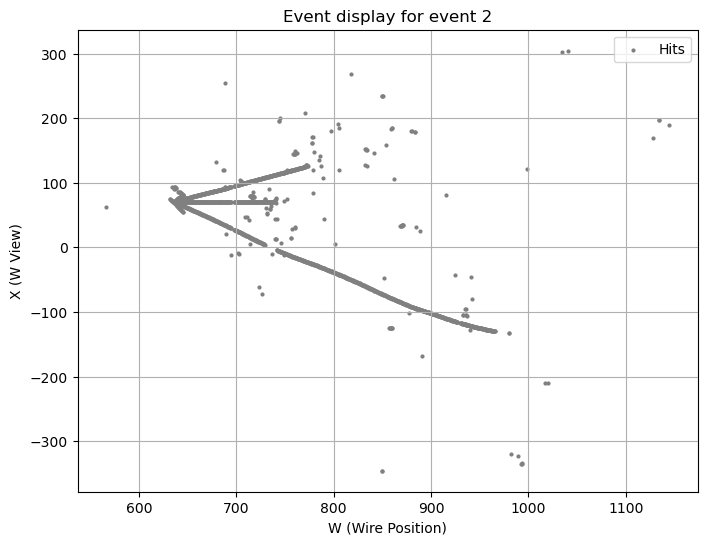

In [2]:
def event_display(events, event_number):
    
    w_hits = np.concatenate(events.filter_by_event(events.reco_hits_w, event_number))
    x_hits = np.concatenate(events.filter_by_event(events.reco_hits_x_w, event_number))
    
    plt.figure(figsize = (8,6))
    plt.scatter(w_hits, x_hits, c='grey', s=4, label='Hits',)
    plt.title(f'Event display for event {event_number}')
    plt.ylabel('X (W View)')
    plt.xlabel('W (Wire Position)')
    plt.legend()
    plt.grid(True)
    plt.show()

event_display(events, 2)

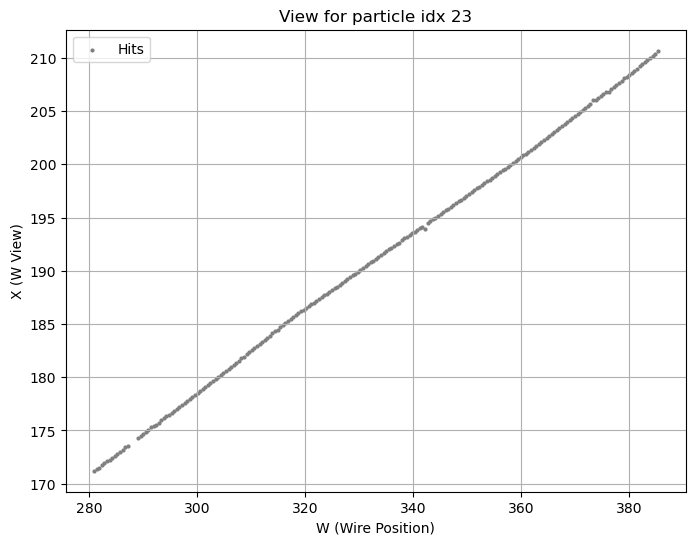

event 171: 3.5878701210021973
event 299: 2.286675214767456
event 410: 8.462183952331543
event 487: 1.1068671941757202
event 521: 2.083752155303955
event 535: 2.051788806915283
event 666: 6.6919941902160645
event 729: 1.2617672681808472
event 767: 1.925671100616455
event 907: 1.2241830825805664
event 926: 0.21563231945037842
event 927: 10.026622772216797
event 1017: 1.2949297428131104
event 1096: 10.92508602142334
event 1189: 8.326533317565918
event 1431: 3.0454459190368652
event 1442: 2.093808174133301
event 1485: 4.06141996383667
event 1518: 6.320855140686035
event 1681: 2.066805601119995
event 1713: 1.8539491891860962
event 1913: 7.217302322387695
event 2032: 1.5343056917190552
event 2047: 1.3431376218795776
event 2157: 0.915949285030365
event 2385: 3.5643723011016846
event 2410: 1.6632649898529053
event 2548: 4.030008792877197
event 2805: 0.9263349175453186
event 2876: 5.232918739318848


In [3]:
def plot_idx(events, event_idx): # defining the function over a single event index, not just the view and then filtering that through for a single event.

    # finding x/w hits again for a single event
    w_hits = events.reco_hits_w[event_idx]
    x_hits = events.reco_hits_x_w[event_idx]

    if len(w_hits) == len(x_hits) and len(w_hits) > 5:
        plt.figure(figsize = (8,6))
        plt.scatter(w_hits, x_hits, c='grey', s=4, label='Hits',)
        plt.title(f'View for particle idx {event_idx}')
        plt.ylabel('X (W View)')
        plt.xlabel('W (Wire Position)')
        plt.legend()
        plt.grid(True)
        plt.show()
    else: return

plot_idx(events, 23)

def rms(events, event_idx, hits_cutoff):
    w_hits = events.reco_hits_w[event_idx]
    x_hits = events.reco_hits_x_w[event_idx]

    if len(w_hits) == len(x_hits) and len(w_hits) > hits_cutoff:
        # Calculate the coefficients for the line of best fit (slope and intercept)
        slope, intercept = np.polyfit(w_hits, x_hits, 1)
    
        # Create numpy arrays for the actual and predicted values
        actual = x_hits
        predicted = slope * w_hits + intercept

        # Calculate the mean squared error (MSE) by taking the mean of the squared differences
        meanSquaredError = ((predicted - actual) ** 2).mean()
    
        # Calculate the RMSE by taking the square root of the MSE
        return np.sqrt(meanSquaredError)
    else: return

for i in range(3000):
    if rms(events, i, 500) is not None:
        print(f'event {i}: {rms(events, i, 500)}')

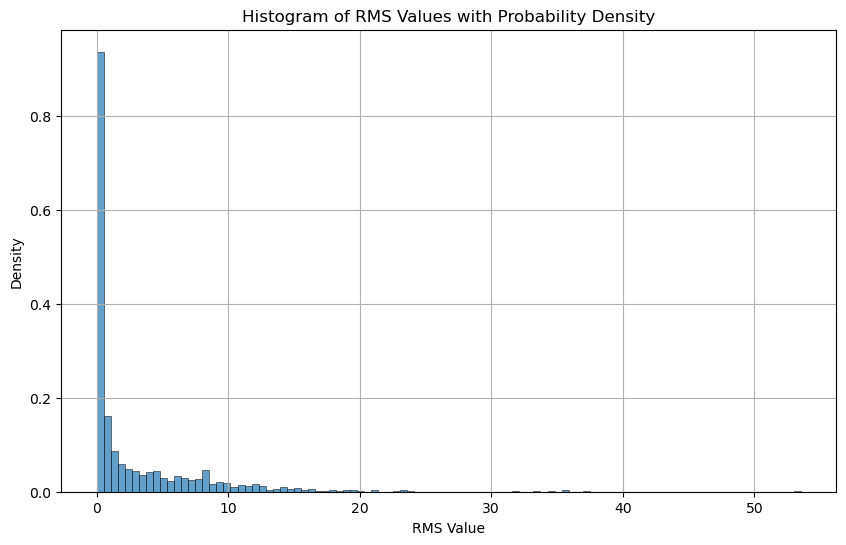

In [4]:
def rms_histogram(events, start_idx, end_idx):
    if not isinstance(start_idx, int) or not isinstance(start_idx, int) or start_idx < 0 or end_idx < 0 or start_idx > end_idx:
        return print('invalid entry of indices')

    rms_values = []
    # loop over all particles between start/end idx inclusive
    for i in range(start_idx, 1 + end_idx):
        rms_values.append(rms(events,i,5))

    # filter out the instances of erroneous events - 5 or less hits, or rms = None
    filtered_rms_values = [x for x in rms_values if x is not None]

    # plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_rms_values, bins=100, density=True, edgecolor='k', linewidth=0.5, alpha=0.7)
    plt.title('Histogram of RMS Values with Probability Density')
    plt.xlabel('RMS Value')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

rms_histogram(events,0,9999)

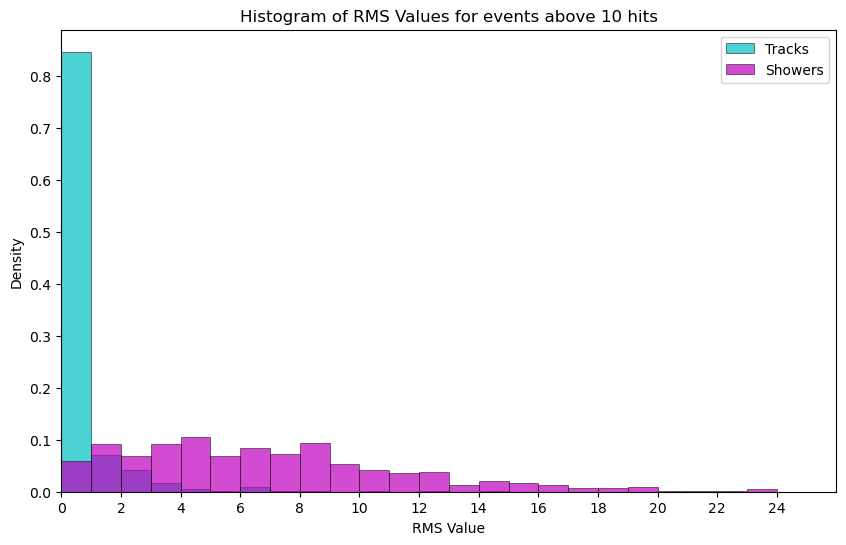

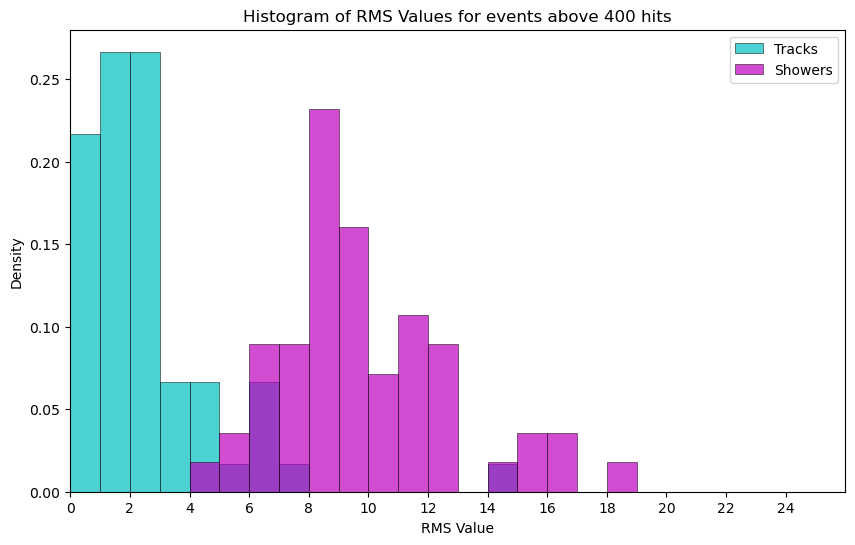

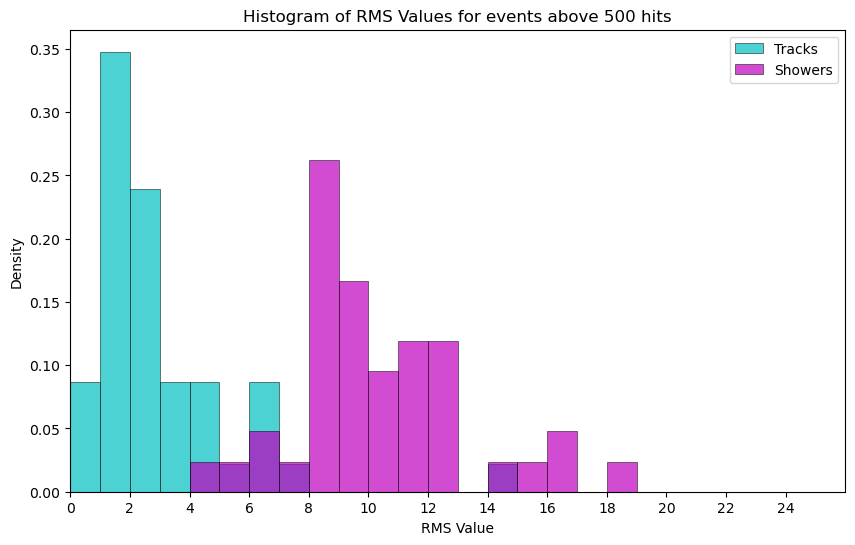

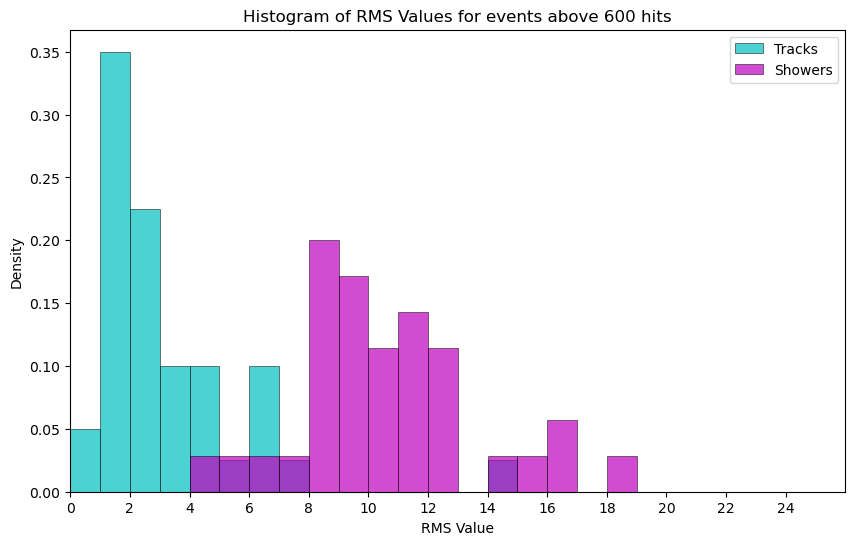

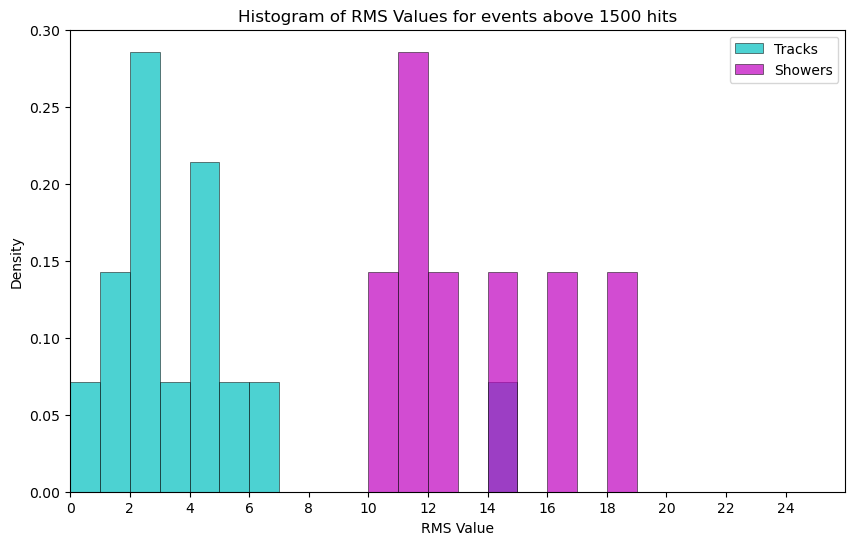

In [5]:
''' now need a way to distinguish pdg codes. the pdg list will be: -11, 11, 22 for showers and all else will be tracks. Will write a new rms function for this '''
shower_mask = [-11, 11, 22] # does what is said above

def rms_pdg(events, event_idx, hits_cutoff):
    w_hits = events.reco_hits_w[event_idx]
    x_hits = events.reco_hits_x_w[event_idx]

    # filtering track or shower from pdg code
    pdg = events.mc_pdg[event_idx]
    track_or_shower = None # initialising the track or shower variable
    if pdg in shower_mask:
        track_or_shower = 'S'
    else: track_or_shower = 'T'

    if len(w_hits) == len(x_hits) and len(w_hits) > hits_cutoff:
        # Calculate the coefficients for the line of best fit (slope and intercept)
        slope, intercept = np.polyfit(w_hits, x_hits, 1)
    
        # Create numpy arrays for the actual and predicted values
        actual = x_hits
        predicted = slope * w_hits + intercept

        # Calculate the mean squared error (MSE) by taking the mean of the squared differences
        meanSquaredError = ((predicted - actual) ** 2).mean()
    
        # Calculate the RMSE by taking the square root of the MSE
        return (np.sqrt(meanSquaredError), track_or_shower)
    else: return


''' Now to write an altered histogram function for the separate tracks and showers '''

def rms_pdg_histogram(start_idx, end_idx, hits_cutoff):
    if not isinstance(start_idx, int) or not isinstance(start_idx, int) or start_idx < 0 or end_idx < 0 or start_idx > end_idx:
        return print('invalid entry of indices')

    track_rms = []
    shower_rms = []
    # loop over all particles between start/end idx inclusive
    for i in range(start_idx, 1 + end_idx):
        try:
            rms_value, indicator = rms_pdg(events, i, hits_cutoff)
            # Proceed to add to the appropriate list based on the indicator
            if rms_value is not None:
                if indicator == 'T':
                    track_rms.append(rms_value)
                elif indicator == 'S':
                    shower_rms.append(rms_value)
        except TypeError:
            # This block will execute if rms_pdg(i) returns None, skipping the unpacking
            pass

    # Calculate the densities
    bin_edges = np.arange(0, 31, 1)
    num_bins = len(bin_edges) - 1  # Number of bins is edges - 1
    track_density, _ = np.histogram(track_rms, bins=np.arange(0, 31, 1), density=True)
    shower_density, _ = np.histogram(shower_rms, bins=np.arange(0, 31, 1), density=True)
    
    # plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(track_rms, bins=bin_edges, density=True, color='c', edgecolor='k', linewidth=0.5, alpha=0.7, label='Tracks')
    plt.hist(shower_rms, bins=bin_edges, density=True, color='m', edgecolor='k', linewidth=0.5, alpha=0.7, label='Showers')
    plt.title(f'Histogram of RMS Values for events above {hits_cutoff} hits')
    plt.xlabel('RMS Value')
    plt.ylabel('Density')
    plt.xticks(np.arange(0, 26, 2))
    plt.xlim(0,26)
    plt.legend()
    plt.grid(False)
    plt.show()

# plotting some instructional histograms
rms_pdg_histogram(0, 9999, 10) # Tracks with few hits are likely to have a near zero RMS so are contributing largely to the 0-1 bin and diluting our data
rms_pdg_histogram(0, 9999, 400) # for the cheated_10 sample, these seem to be a sweet spot
rms_pdg_histogram(0, 9999, 500)
rms_pdg_histogram(0, 9999, 600)
rms_pdg_histogram(0, 9999, 1500) # too strong of a cut

In [6]:
''' Now why don't we use a more numerical approach to find a critical rms? '''
# take the "middle" of the track and showers across a cutoff number looped over 300-500 step size of 10
# is the numerical mean of all of these "middle"s good enough?
# lets just see...

crit = []
for k in np.arange(300,500,10):
    for l in range(0,9999):
        if rms_pdg(events,l,k) != None:
            crit.append(rms_pdg(events, l, k))

filtered_data = [(value, indicator) for value, indicator in crit if 4 <= value <= 8]

# Extract values between 4 and 8 and sort them
values = sorted([value for value, indicator in filtered_data])

# Find the median as the critical value
n = len(values)
if n % 2 == 1:
    # Odd number of elements: median is the middle element
    critical_value = values[n // 2]
else:
    # Even number of elements: median is the average of the two middle elements
    critical_value = (values[n // 2 - 1] + values[n // 2]) / 2

print(f'critical value: {critical_value}, of a median approach')

# just taken an arithmetic mean over the overlap, is there a better approach?
# instead of just taking a mean, we need a value for which deviating either side causes a switch in change of sign?
# so if we had a smooth function that traced the histograms perfectly, what would the intercept be?

critical value: 6.320855140686035, of a median approach


In [7]:
def track_or_shower_median(events, event_idx, hits_cutoff, rms_error):
    rms_h = rms(events, event_idx, hits_cutoff)
    if rms_h == None:
        return
    else:
        if rms_h < 6.321 - rms_error:
            print(f'Event {event_idx} is likely a track')
        elif rms_h > 6.321 + rms_error:
            print(f'Event {event_idx} is likely a shower')
        else: print(f'Event {event_idx} is ambiguous')

for i in range(100):
    track_or_shower_median(events,i,400,0.5)

Event 666 is ambiguous


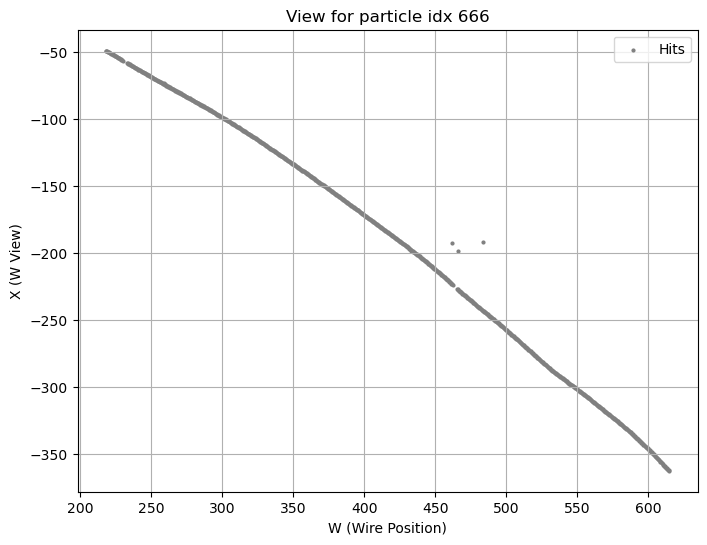

Event 1518 is ambiguous


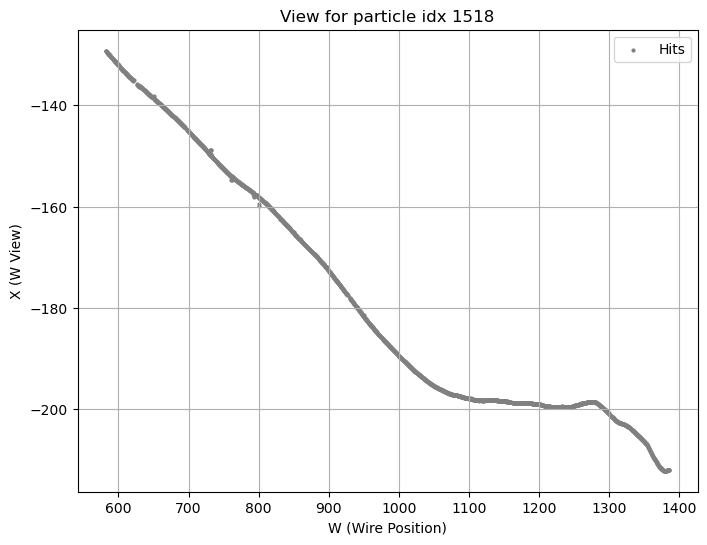

Event 2370 is likely a track


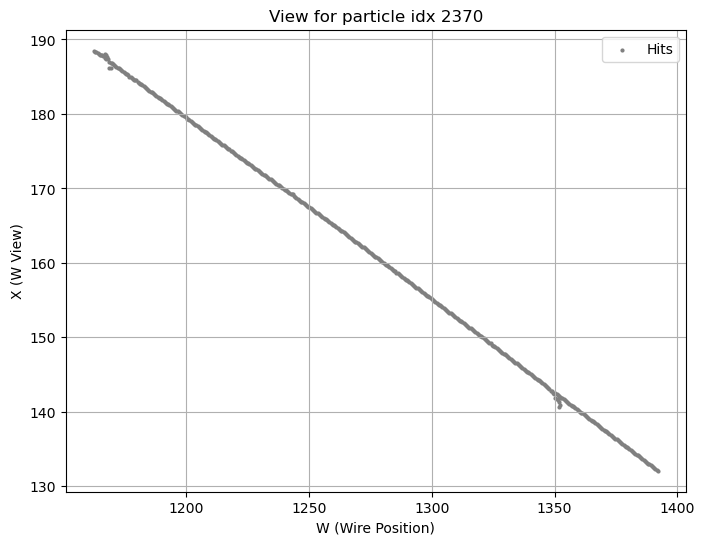

Event 3011 is likely a shower


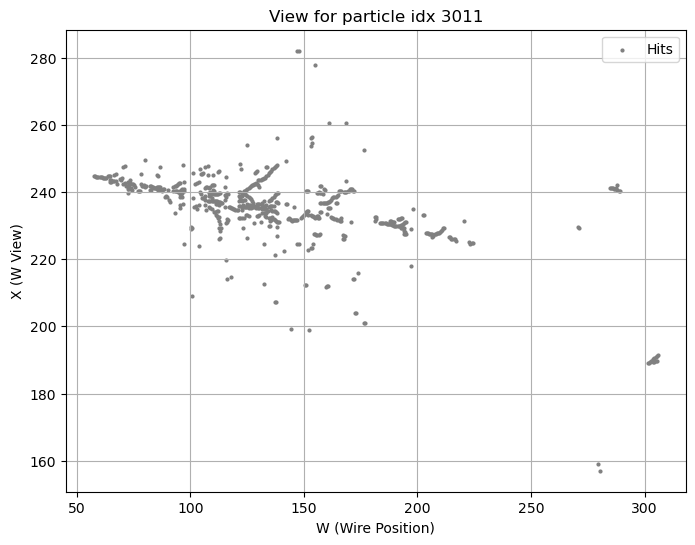

In [8]:
''' Lets plot a few of these '''
idx = [666, 1518, 2370, 3011]

for i in idx:
    track_or_shower_median(events, i, 400, rms_error=0.5)
    plot_idx(events, i)

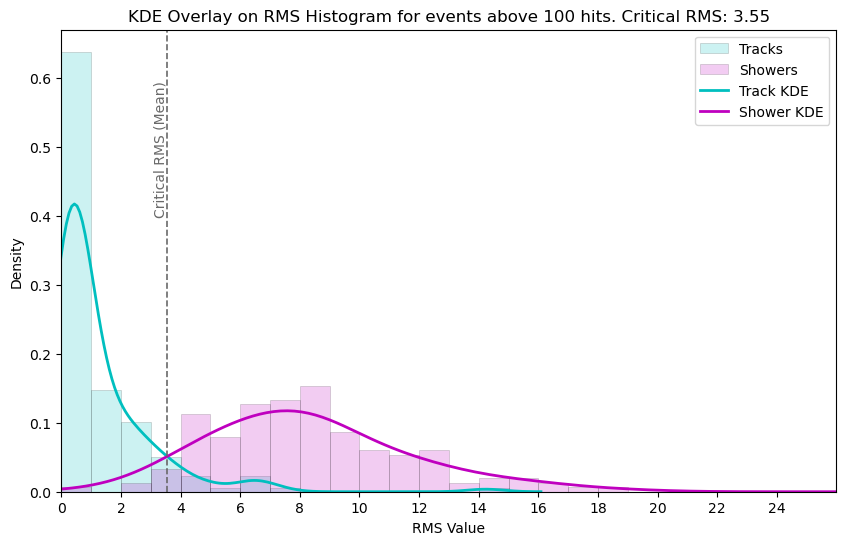

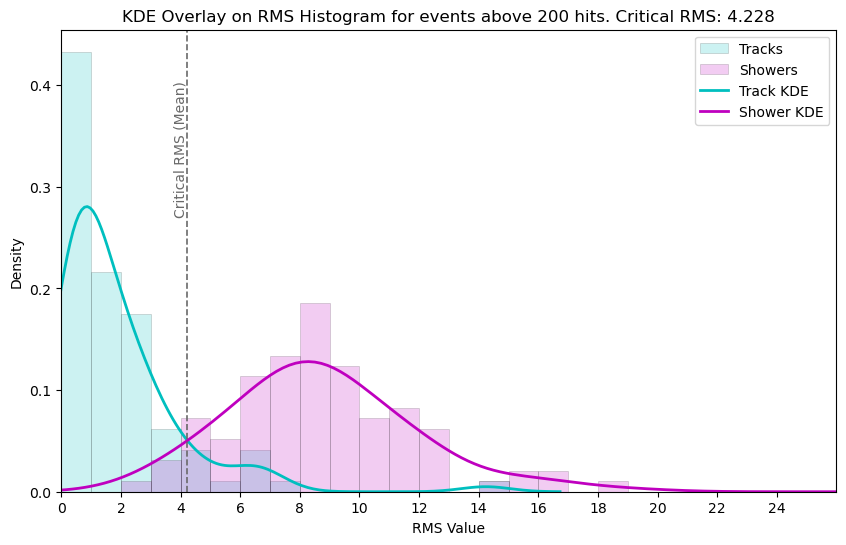

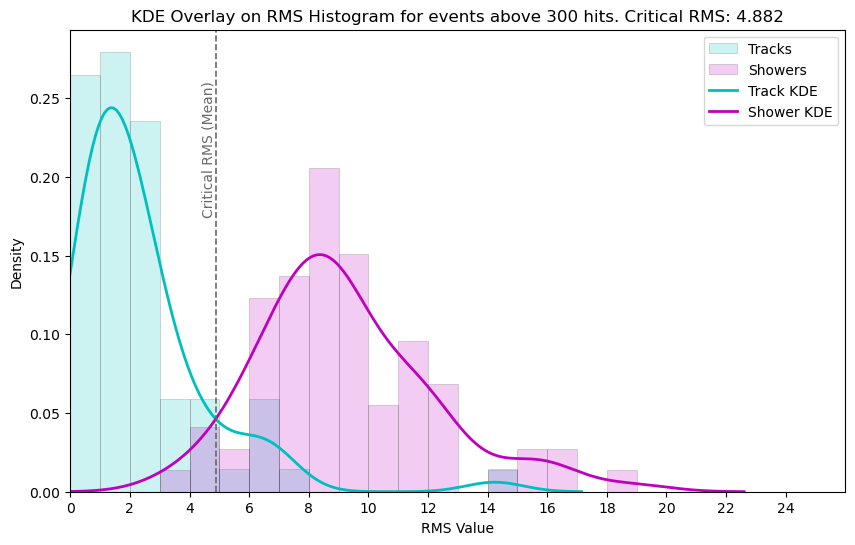

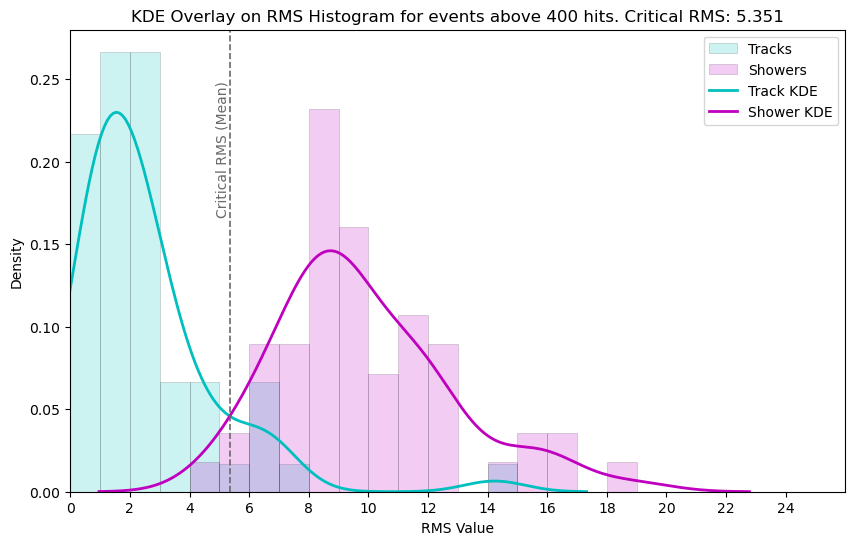

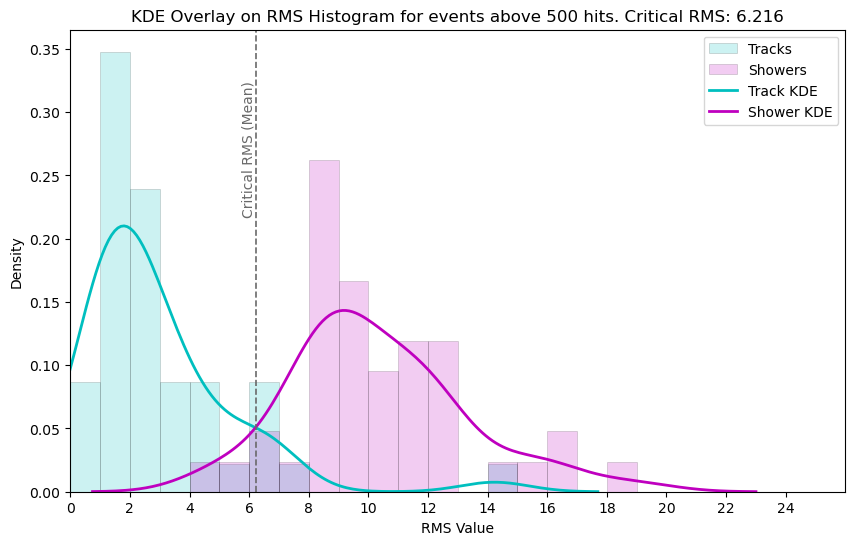

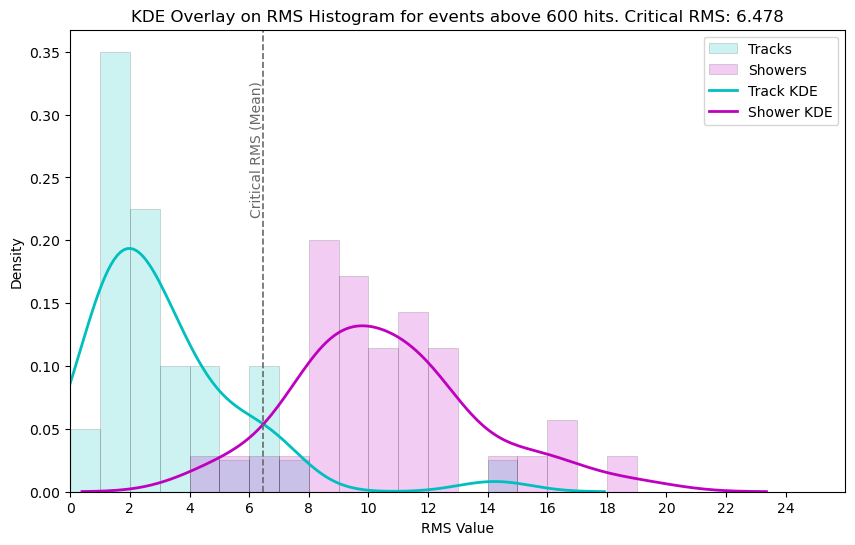

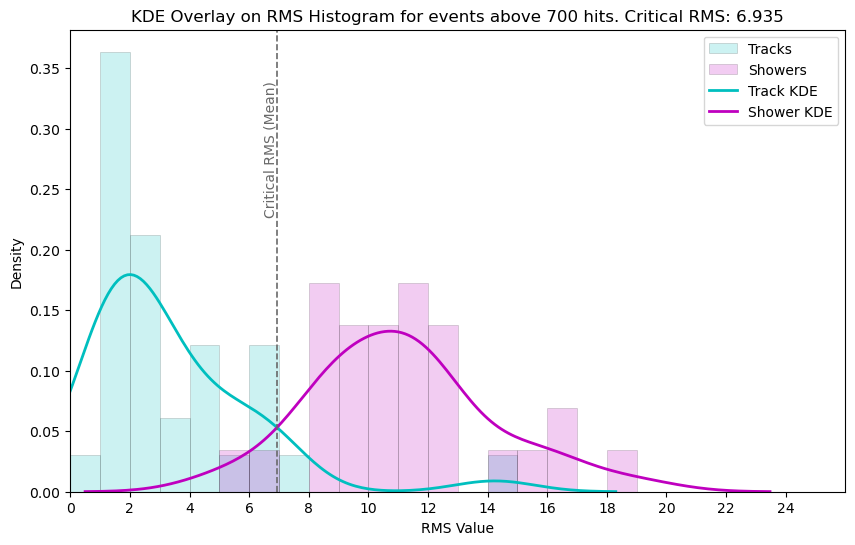

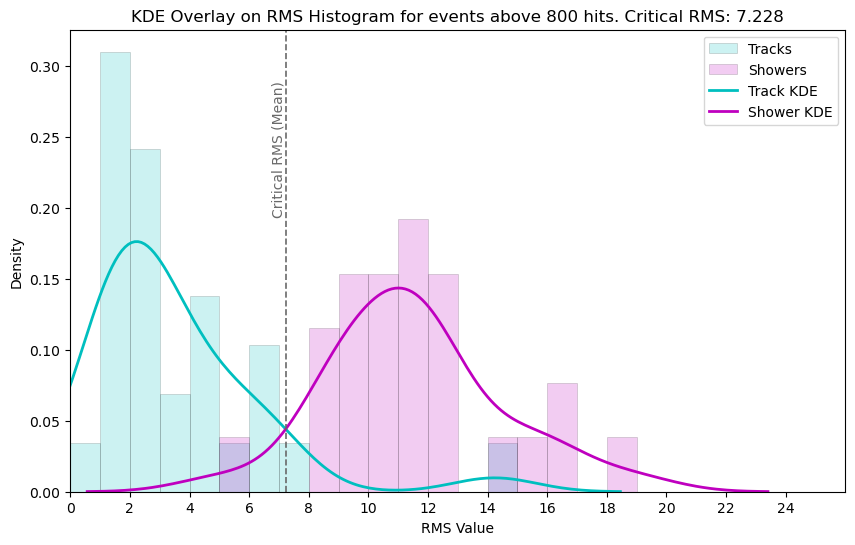

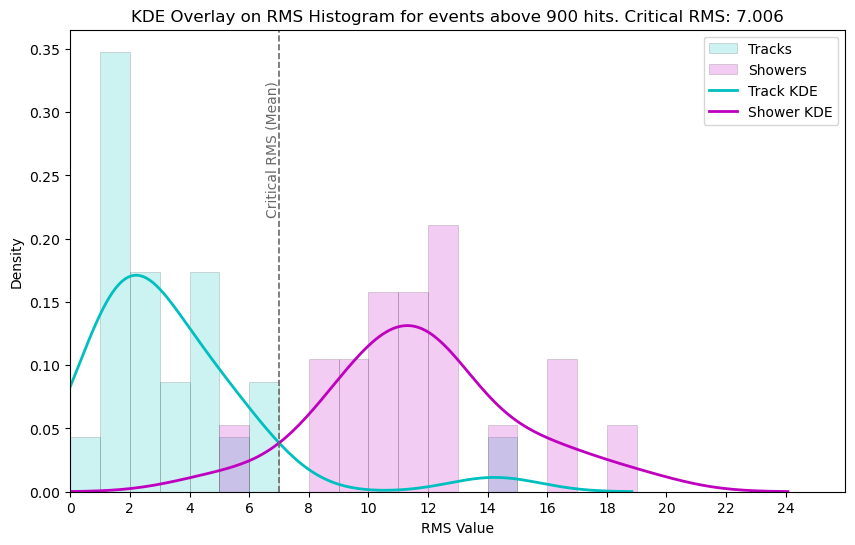

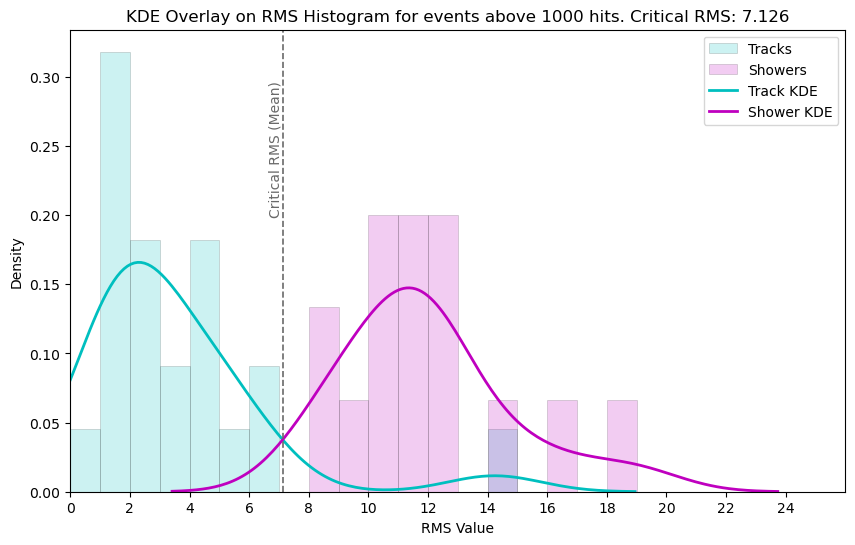

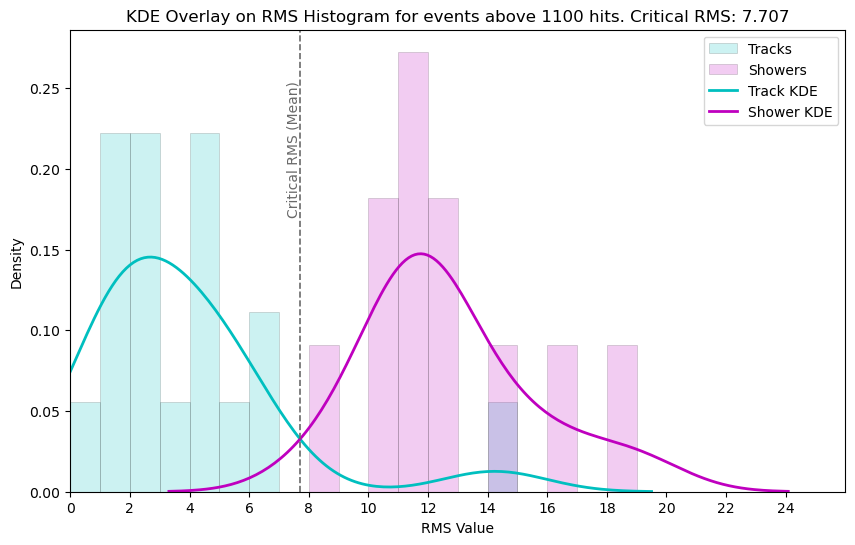

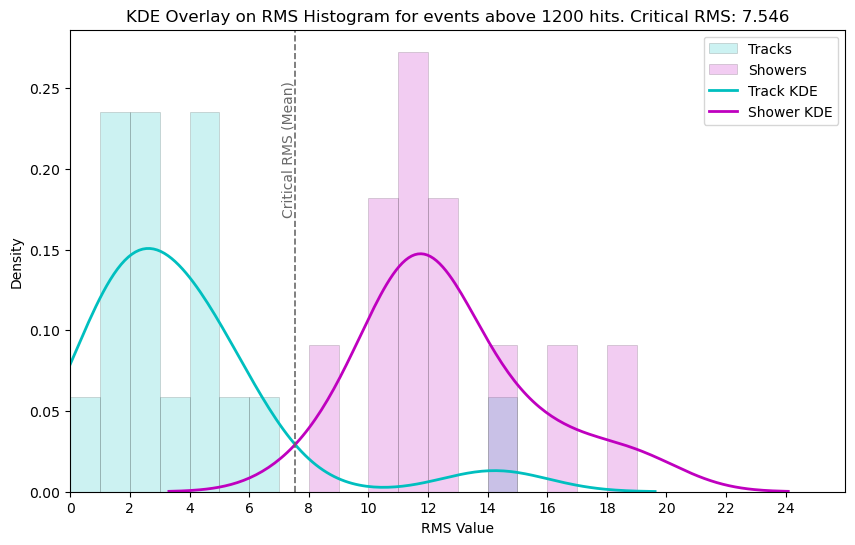

In [9]:
''' Using a smooth density plot to find the intercept, and try that as a critical value '''
import seaborn as sns
from scipy.stats import gaussian_kde

import numpy as np
import matplotlib.pyplot as plt

def find_median(arr): # finding the median so that we can look for the critical value between the medians of track and shower
    # Sort the array
    sorted_arr = sorted(arr)
    n = len(sorted_arr)
    
    # If the array length is odd, return the middle element
    if n % 2 == 1:
        return sorted_arr[n // 2]
    # If the array length is even, return the average of the two middle elements
    else:
        mid1, mid2 = sorted_arr[n // 2 - 1], sorted_arr[n // 2]
        return (mid1 + mid2) / 2


def rms_kde(events, start_idx, end_idx, hits_cutoff):
    # Validate inputs
    if not isinstance(start_idx, int) or not isinstance(end_idx, int) or start_idx < 0 or end_idx < 0 or start_idx > end_idx:
        return print('Invalid entry of indices')

    track_rms = []
    shower_rms = []
    
    # Loop over all particles between start/end idx inclusive
    for i in range(start_idx, 1 + end_idx):
        try:
            rms_value, indicator = rms_pdg(events, i, hits_cutoff)
            if rms_value is not None:
                if indicator == 'T':
                    track_rms.append(rms_value)
                elif indicator == 'S':
                    shower_rms.append(rms_value)
        except TypeError:
            pass

    # Define bin edges for the histogram
    bin_edges = np.arange(0, 31, 1)
    
    # Plot the histograms
    plt.figure(figsize=(10, 6))
    plt.hist(track_rms, bins=bin_edges, density=True, color='c', edgecolor='k', linewidth=0.5, alpha=0.2, label='Tracks')
    plt.hist(shower_rms, bins=bin_edges, density=True, color='m', edgecolor='k', linewidth=0.5, alpha=0.2, label='Showers')
    
    # KDE Plots using seaborn for visualization
    sns.kdeplot(track_rms, color='c', linewidth=2, label='Track KDE')
    sns.kdeplot(shower_rms, color='m', linewidth=2, label='Shower KDE')

    # Calculate KDE intersections using scipy's gaussian_kde
    track_rms_med = find_median(track_rms)
    shower_rms_med = find_median(shower_rms)
    
    x_values = np.linspace(track_rms_med, shower_rms_med, 1500)  # Shared x-range for KDEs, critical rms will be between the medians
    track_kde = gaussian_kde(track_rms)
    shower_kde = gaussian_kde(shower_rms)
    track_density = track_kde(x_values)
    shower_density = shower_kde(x_values)
    
    # Find intersection points
    intersections = x_values[np.isclose(track_density, shower_density, atol=1e-3)]
    
    # Calculate the mean of intersection points if any intersections exist
    mean_intersection = 0
    if intersections.size > 0:
        mean_intersection = intersections.mean()
        
        # Plot the mean intersection point
        plt.axvline(mean_intersection, color='dimgrey', linestyle='--', linewidth=1.2)

        y_lim = plt.ylim()
        y_text = y_lim[0] + 0.6 * (y_lim[1] - y_lim[0])
        plt.text(mean_intersection, y_text, 'Critical RMS (Mean)', rotation=90, color='dimgrey', ha='right')
    else:
        print("No intersections found.")
    
    # Finalize plot with labels and legend
    plt.title(f'KDE Overlay on RMS Histogram for events above {hits_cutoff} hits. Critical RMS: {mean_intersection.round(3) if mean_intersection is not None else mean_intersection}')
    plt.xlabel('RMS Value')
    plt.ylabel('Density')
    plt.xticks(np.arange(0, 26, 2))
    plt.xlim(0, 26)
    plt.legend()
    plt.grid(False)
    plt.show()


# plotting some instructional histograms
for i in np.arange(100, 1201, 100):
    rms_kde(events, 0, 9999, i)

# Seemingly we either need a larger sample size, or we need to parametrise the critical value of the rms as a function of the number of hits in the event, since it seems to crawl up.

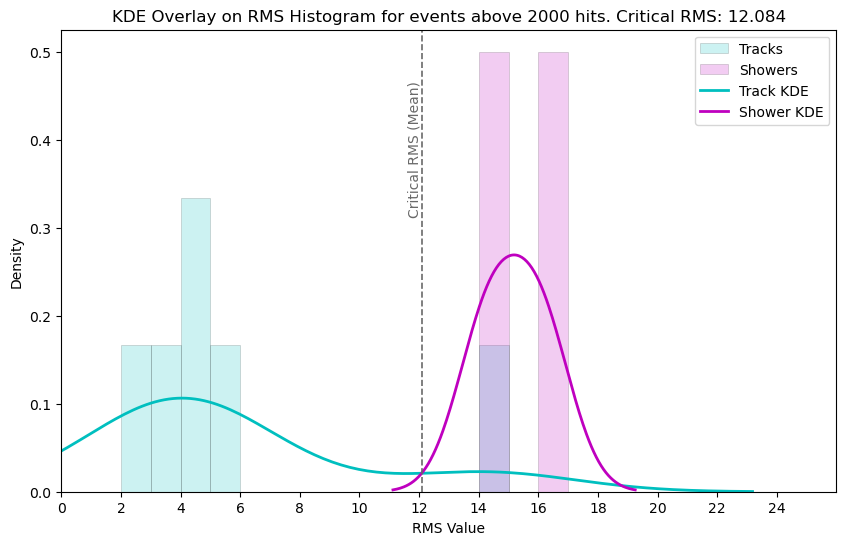

In [10]:
rms_kde(events, 0, 9999, 2000)

# Consensus right now:

Can get some estimates of a critical rms, may want to take cutoffs every 50 between 200 and 800 for example and take the values in an array, could take a mean, could be weighted. I think weighing the entries may be slightly too far, an arithmetic mean should be fine.

Then we need some form of confidence % that will look at a few things:
1) Track or shower
2) If the RMS leans track or shower, what percentage of the RMS values that lie PAST the given RMS are correct, sort of like how hypothesis testing works for a normal distribution. We take an integral of the Gaussians to the right and take a percentage for the confidence.
3) Once we have a way to find the confidence, we can combine this into a function that prints f'event {event_idx} has rms {rmse} which is a {t_or_s} with {conf}% confidence'

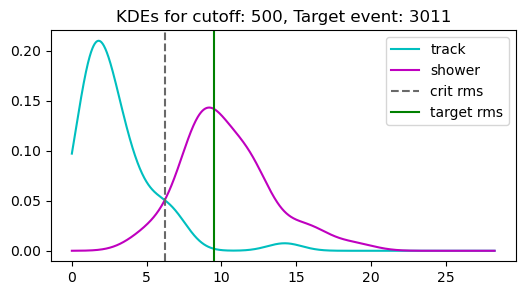

^ The RMS of event 3011 is 9.484386444091797, it is a SHOWER with a 82.098% confidence


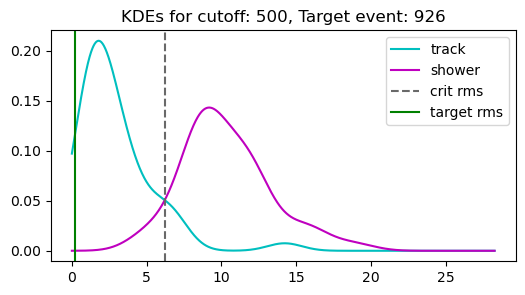

^ The RMS of event 926 is 0.21563231945037842, it is a TRACK with a 91.17222% confidence


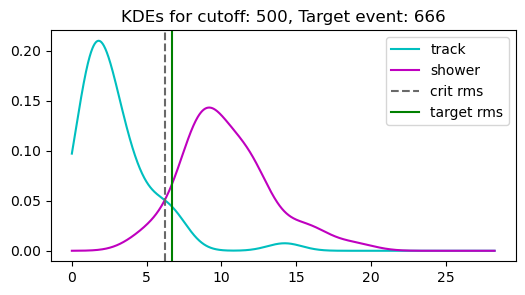

^ The RMS of event 666 is 6.6919941902160645, it is a SHOWER with a 54.97% confidence


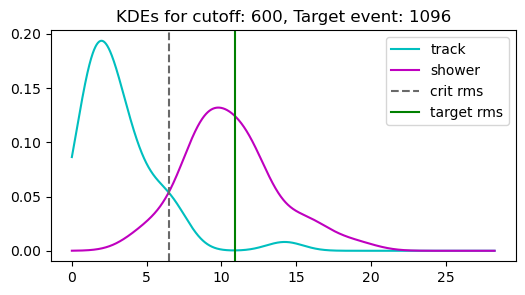

^ The RMS of event 1096 is 10.92508602142334, it is a SHOWER with a 86.423% confidence
^ The RMS of event 1518 is 6.320855140686035, it is a SHOWER with a 51.178000000000004% confidence


[6.320855, 'S', 0.5117835383324297]

In [11]:
def track_or_shower_confidence(events, start_idx, end_idx, hits_cutoff, target_idx, show_plot):
    # Validate inputs
    if not isinstance(start_idx, int) or not isinstance(end_idx, int) or not isinstance(target_idx, int) or start_idx < 0 or end_idx < 0 or not start_idx <= target_idx <= end_idx:
        return print('Invalid entry of indices')
    
    track_rms = []
    shower_rms = []
    
    # Loop over all particles between start/end idx inclusive
    for i in range(start_idx, 1 + end_idx):
        try:
            rms_value, indicator = rms_pdg(events, i, hits_cutoff)
            if rms_value is not None:
                if indicator == 'T':
                    track_rms.append(rms_value)
                elif indicator == 'S':
                    shower_rms.append(rms_value)
        except TypeError:
            pass

    # Calculate KDE intersections using scipy's gaussian_kde
    track_rms_med = find_median(track_rms)
    shower_rms_med = find_median(shower_rms)
    
    x_values = np.linspace(track_rms_med, shower_rms_med, 1500)  # Shared x-range for KDEs, critical rms will be between the medians
    track_kde = gaussian_kde(track_rms)
    shower_kde = gaussian_kde(shower_rms)
    track_density = track_kde(x_values)
    shower_density = shower_kde(x_values)
    
    # Find intersection points
    intersections = x_values[np.isclose(track_density, shower_density, atol=1e-3)]
    
    # Calculate the mean of intersection points if any intersections exist
    rms_crit = None
    if intersections.size > 0:
        rms_crit = intersections.mean()
    else:
        print("No intersections found.")

    # Need to find the same gaussians now, but for a linspace that goes across the whole space:
    x_values_conf = np.linspace(0, 1.5*max([max(shower_rms), max(track_rms)]), 1500)
    track_conf = track_kde(x_values_conf)
    shower_conf = shower_kde(x_values_conf)
    
    target_rms = rms(events, target_idx, hits_cutoff)
    if target_rms == None:
        print(f'Cutoff is too large for event {target_idx} or an error found with calculating RMS')
        return [None, None, None]
    elif target_rms == rms_crit:
        print('RMS is the critical value, unable to discern')
        return [target_rms, 'U', 0.5] # Unknown with 50% confidence, sort of pointless informtion really.
    elif target_rms > rms_crit:
        
        # Define the limits for integration
        lower_limit = rms_crit
        upper_limit = target_rms
        
        if show_plot:
            plt.figure(figsize = (6,3))
            plt.plot(x_values_conf, track_conf, c='c', label='track')
            plt.plot(x_values_conf, shower_conf, c='m', label='shower')
            plt.axvline(rms_crit, c='dimgray', linestyle='--', label='crit rms')
            plt.axvline(target_rms, c='g', label='target rms')
            plt.title(f'KDEs for cutoff: {hits_cutoff}, Target event: {target_idx}')
            plt.legend()
            plt.show()
    
        # Create a mask to filter values within the specified limits
        mask_track = (x_values_conf >= lower_limit) & (x_values_conf <= upper_limit)
        mask_shower = (x_values_conf >= lower_limit) & (x_values_conf <= upper_limit)
    
        # Perform trapezoidal integration within the specified limits
        area_track = np.trapz(track_conf[mask_track], x_values_conf[mask_track])
        area_shower = np.trapz(shower_conf[mask_shower], x_values_conf[mask_shower])
        conf = area_shower/(area_track + area_shower)
        
        print(f'^ The RMS of event {target_idx} is {target_rms}, it is a SHOWER with a {100*(conf.round(5))}% confidence')
        return [target_rms, 'S', conf]

    elif target_rms < rms_crit:
        
        # Define the limits for integration
        lower_limit = target_rms
        upper_limit = rms_crit
        
        if show_plot:
            plt.figure(figsize = (6,3))
            plt.plot(x_values_conf, track_conf, c='c', label='track')
            plt.plot(x_values_conf, shower_conf, c='m', label='shower')
            plt.axvline(rms_crit, c='dimgray', linestyle='--', label='crit rms')
            plt.axvline(target_rms, c='g', label='target rms')
            plt.title(f'KDEs for cutoff: {hits_cutoff}, Target event: {target_idx}')
            plt.legend()
            plt.show()
    
        # Create a mask to filter values within the specified limits
        mask_track = (x_values_conf >= lower_limit) & (x_values_conf <= upper_limit)
        mask_shower = (x_values_conf >= lower_limit) & (x_values_conf <= upper_limit)
    
        # Perform trapezoidal integration within the specified limits
        area_track = np.trapz(track_conf[mask_track], x_values_conf[mask_track])
        area_shower = np.trapz(shower_conf[mask_shower], x_values_conf[mask_shower])
        conf = area_track/(area_shower + area_track)
        
        print(f'^ The RMS of event {target_idx} is {target_rms}, it is a TRACK with a {100*conf:.5f}% confidence')
        return [target_rms, 'T', conf]
    else: return


track_or_shower_confidence(events, start_idx=0, end_idx=9999, hits_cutoff=500, target_idx=3011, show_plot=True)
track_or_shower_confidence(events, start_idx=0, end_idx=9999, hits_cutoff=500, target_idx=926, show_plot=True)
track_or_shower_confidence(events, start_idx=0, end_idx=9999, hits_cutoff=500, target_idx=666, show_plot=True)

track_or_shower_confidence(events, 0, 9999, 600, 1096, True)
track_or_shower_confidence(events, 0, 9999, 500, 1518, False)

In [12]:
likelihoods = np.array([])

#for j in range(0,9999):
#    confidence = track_or_shower_confidence(events, 0, 9999, 500, j, False)
#    likelihoods = np.append(likelihoods, confidence)
#
#print(likelihoods)